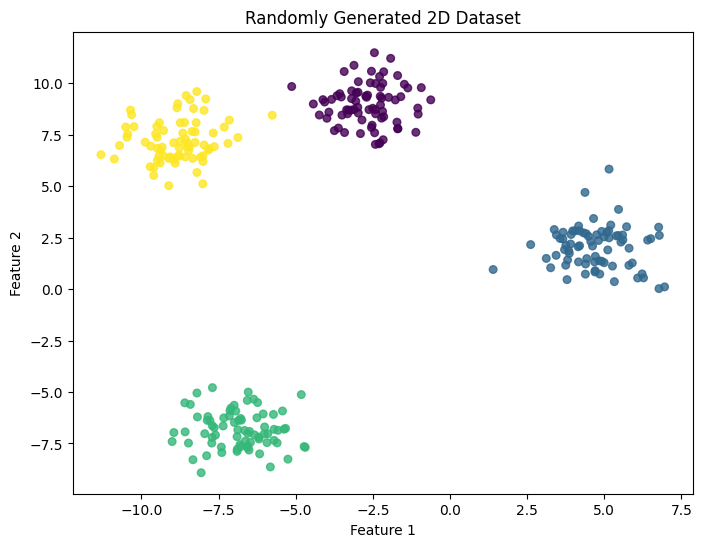

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate random datasets
def generate_random_dataset(n_samples=500, n_features=2, n_clusters=5, random_state=42):
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=random_state)
    return X, y

# Generate a 2D dataset for visualization
X_2D, y_2D = generate_random_dataset(n_samples=300, n_features=2, n_clusters=4, random_state=42)

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y_2D, cmap="viridis", s=30, alpha=0.8)
plt.title("Randomly Generated 2D Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

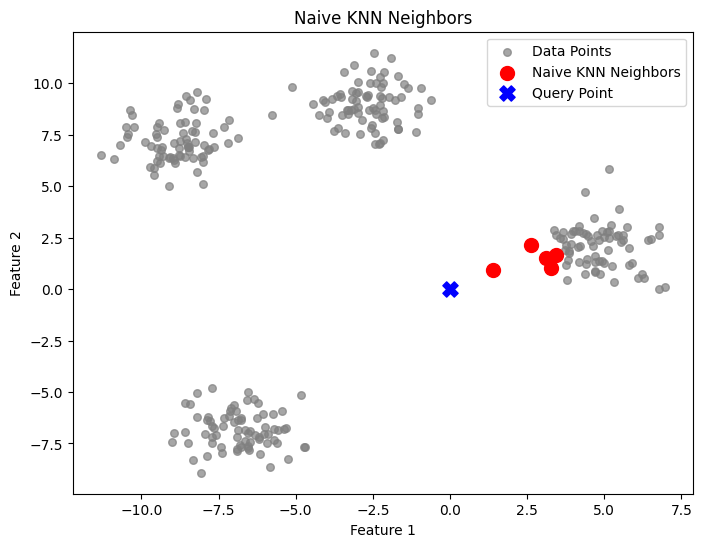

In [24]:
def naive_knn(X, query, k):
    distances = np.linalg.norm(X - query, axis=1)
    indices = np.argsort(distances)[:k]
    return indices, distances[indices]

# Test on a sample query
query_point = np.array([0, 0])  # Example query
k = 5
indices_naive, distances_naive = naive_knn(X_2D, query_point, k)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c='gray', s=30, alpha=0.7, label="Data Points")
plt.scatter(X_2D[indices_naive, 0], X_2D[indices_naive, 1], c='red', s=100, label="Naive KNN Neighbors")
plt.scatter(query_point[0], query_point[1], c='blue', s=120, marker='X', label="Query Point")
plt.title("Naive KNN Neighbors")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

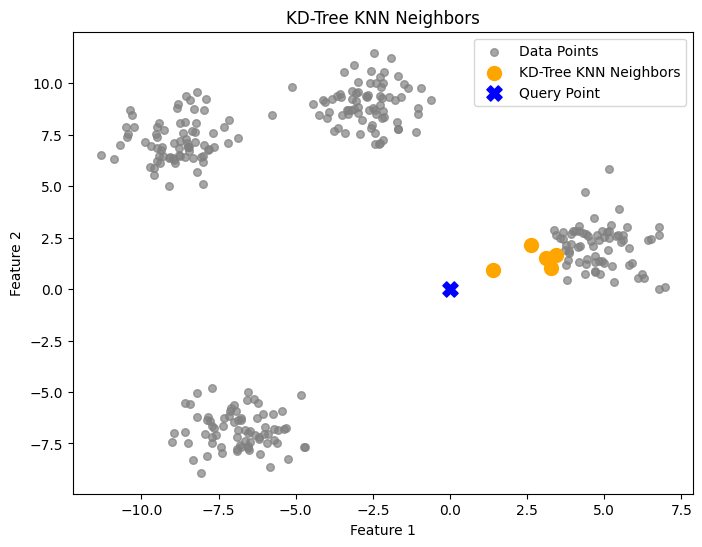

In [25]:
from sklearn.neighbors import KDTree

def kd_tree_knn(X, query, k):
    tree = KDTree(X, leaf_size=30)
    distances, indices = tree.query(query.reshape(1, -1), k=k)
    return indices[0], distances[0]

# Test KD-Tree KNN
indices_kdtree, distances_kdtree = kd_tree_knn(X_2D, query_point, k)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c='gray', s=30, alpha=0.7, label="Data Points")
plt.scatter(X_2D[indices_kdtree, 0], X_2D[indices_kdtree, 1], c='orange', s=100, label="KD-Tree KNN Neighbors")
plt.scatter(query_point[0], query_point[1], c='blue', s=120, marker='X', label="Query Point")
plt.title("KD-Tree KNN Neighbors")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(


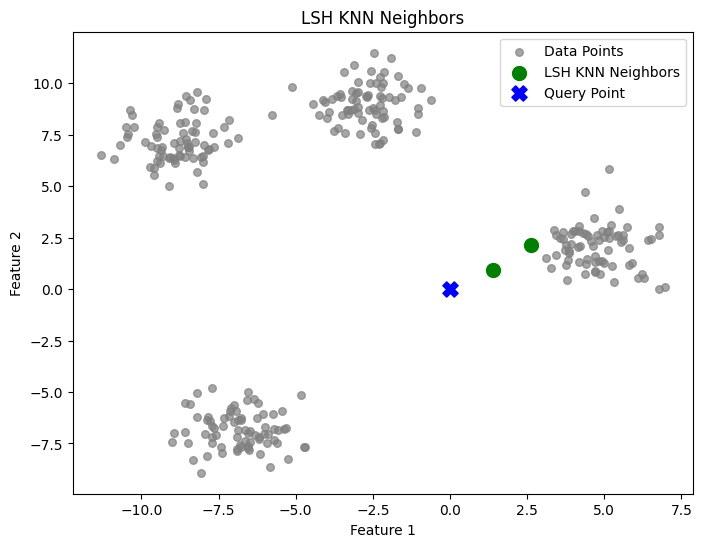

In [26]:
from sklearn.random_projection import SparseRandomProjection

class LSH:
    def __init__(self, n_hashes, n_dimensions):
        self.n_hashes = n_hashes
        self.projections = SparseRandomProjection(n_components=n_hashes)
        self.hash_buckets = {}
    
    def fit(self, X):
        hash_keys = self.projections.fit_transform(X).astype(int)
        self.hash_buckets = {tuple(row): [] for row in hash_keys}
        for i, key in enumerate(hash_keys):
            self.hash_buckets[tuple(key)].append(i)
    
    def query(self, X, query, k):
        query_key = tuple(self.projections.transform(query.reshape(1, -1)).astype(int)[0])
        candidates = []
        if query_key in self.hash_buckets:
            candidates = self.hash_buckets[query_key]
        if not candidates:
            return naive_knn(X, query, k)[0]
        else:
            candidates = np.array(candidates)
            distances = np.linalg.norm(X[candidates] - query, axis=1)
            sorted_indices = np.argsort(distances)[:k]
            return candidates[sorted_indices]

# Initialize and fit LSH
lsh = LSH(n_hashes=10, n_dimensions=2)
lsh.fit(X_2D)

# Query LSH
indices_lsh = lsh.query(X_2D, query_point, k)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c='gray', s=30, alpha=0.7, label="Data Points")
plt.scatter(X_2D[indices_lsh, 0], X_2D[indices_lsh, 1], c='green', s=100, label="LSH KNN Neighbors")
plt.scatter(query_point[0], query_point[1], c='blue', s=120, marker='X', label="Query Point")
plt.title("LSH KNN Neighbors")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


In [27]:
import time

def measure_time_and_memory(X, query, k):
    methods = {
        "Naive": naive_knn,
        "KD-Tree": kd_tree_knn,
    }
    
    results = {}
    for method_name, method in methods.items():
        start_time = time.time()
        indices, distances = method(X, query, k)
        elapsed_time = time.time() - start_time
        results[method_name] = elapsed_time
    
    # Add LSH separately
    start_time = time.time()
    indices = lsh.query(X, query, k)
    elapsed_time = time.time() - start_time
    results["LSH"] = elapsed_time

    return results

query = np.array([0, 0])  # Same query point
performance = measure_time_and_memory(X_2D, query, k)
print("Performance (Time in Seconds):", performance)


Performance (Time in Seconds): {'Naive': 0.0010378360748291016, 'KD-Tree': 0.0, 'LSH': 0.0015070438385009766}


In [28]:
!pip install memory_profiler


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\random_projectio

    Dataset Size  Dimensions  Naive Time  Naive Memory  KD-Tree Time  \
0            100           2   11.635236    208.542969      6.215937   
1            100          10   11.071829    208.542969      6.356534   
2            100          20   10.975753    208.542969      6.301059   
3            100          50   10.409396    208.542969      6.112085   
4            500           2    5.343326    208.542969      2.941090   
5            500          10    3.025048    208.542969      3.153397   
6            500          20    2.699791    208.550781      2.692275   
7            500          50    2.675843    208.566406      2.871738   
8           1000           2    2.981056    208.566406      2.687210   
9           1000          10    2.782205    208.566406      2.745754   
10          1000          20    2.959013    208.792969      2.784139   
11          1000          50    2.736191    209.574219      2.915782   
12          5000           2    3.115524    209.578125      2.97

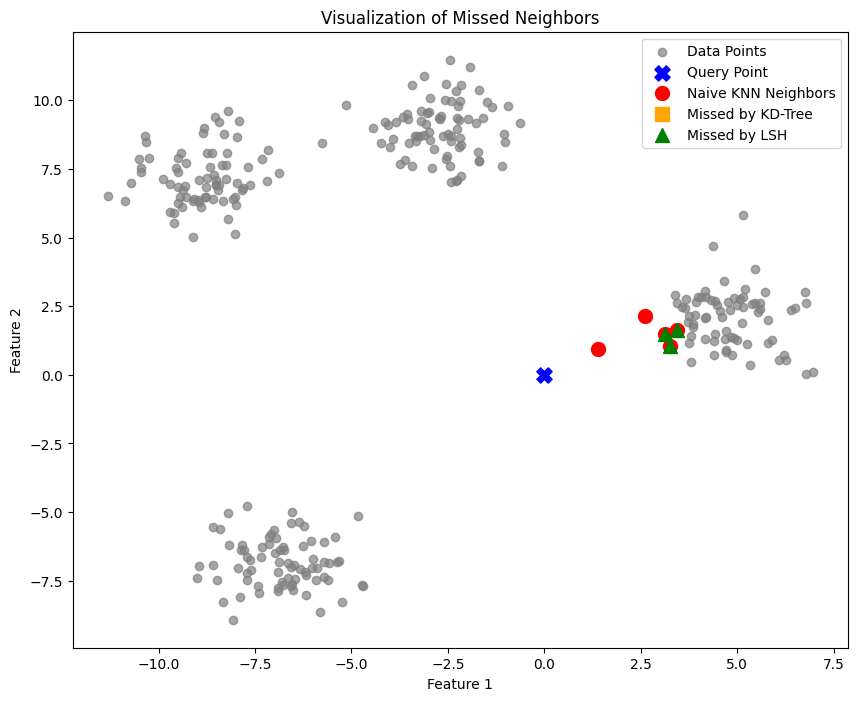

In [29]:
from memory_profiler import memory_usage

# Function to test different dataset sizes and dimensions
def performance_comparison():
    dataset_sizes = [100, 500, 1000, 5000]
    dimensions = [2, 10, 20, 50]
    results = []

    for N in dataset_sizes:
        for D in dimensions:
            X, _ = generate_random_dataset(n_samples=N, n_features=D)
            query = np.random.rand(D)
            k = 5

            row = {"Dataset Size": N, "Dimensions": D}

            for method_name, method in {"Naive": naive_knn, "KD-Tree": kd_tree_knn}.items():
                start_time = time.time()
                mem_usage = memory_usage((method, (X, query, k)), max_usage=True)
                elapsed_time = time.time() - start_time
                row[f"{method_name} Time"] = elapsed_time
                row[f"{method_name} Memory"] = mem_usage
            
            # LSH
            lsh = LSH(n_hashes=10, n_dimensions=D)
            lsh.fit(X)
            start_time = time.time()
            mem_usage = memory_usage((lsh.query, (X, query, k)), max_usage=True)
            elapsed_time = time.time() - start_time
            row["LSH Time"] = elapsed_time
            row["LSH Memory"] = mem_usage

            results.append(row)

    return results

# Run performance comparison
comparison_results = performance_comparison()

# Display results
import pandas as pd
df_results = pd.DataFrame(comparison_results)
print(df_results)

# Visualizing Missed Neighbors
def visualize_missed_neighbors(X, query, k):
    # Get results from all methods
    indices_naive, _ = naive_knn(X, query, k)
    indices_kdtree, _ = kd_tree_knn(X, query, k)
    indices_lsh = lsh.query(X, query, k)

    # Identify missed neighbors
    missed_kdtree = set(indices_naive) - set(indices_kdtree)
    missed_lsh = set(indices_naive) - set(indices_lsh)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c='gray', alpha=0.7, label="Data Points")
    plt.scatter(query[0], query[1], c='blue', s=120, marker='X', label="Query Point")
    plt.scatter(X[indices_naive, 0], X[indices_naive, 1], c='red', label="Naive KNN Neighbors", s=100)
    plt.scatter(X[list(missed_kdtree), 0], X[list(missed_kdtree), 1], c='orange', marker='s', label="Missed by KD-Tree", s=100)
    plt.scatter(X[list(missed_lsh), 0], X[list(missed_lsh), 1], c='green', marker='^', label="Missed by LSH", s=100)
    plt.title("Visualization of Missed Neighbors")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

# Run visualization
visualize_missed_neighbors(X_2D, query_point, k)
